### TensorFlow Object Detection API

#### Download TF models

```bash
$ git clone https://github.com/tensorflow/models
$ cd models/research/
$ protoc object_detection/protos/*.proto --python_out=.
$ cd ../..
```

#### Download models

```bash
$ ./download_model.sh 
```

***

In [1]:
import sys
import os
import tensorflow as tf

In [2]:
import numpy as np
from PIL import Image
from PIL import ImageDraw

In [3]:
sys.path.insert(0, './models/research')
from object_detection.utils import label_map_util

In [4]:
MODEL_BASE = 'models/research'
sys.path.append(MODEL_BASE)
sys.path.append(MODEL_BASE + '/object_detection')
sys.path.append(MODEL_BASE + '/slim')

In [5]:
PATH_TO_CKPT = os.getcwd() + '/graph_def/frozen_inference_graph.pb'
PATH_TO_LABELS = MODEL_BASE + '/object_detection/data/mscoco_label_map.pbtxt'

In [6]:
class ObjectDetector(object):
    def __init__(self):
        self.detection_graph = self._build_graph()
        self.sess = tf.Session(graph=self.detection_graph)
        
        label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
        categories = label_map_util.convert_label_map_to_categories(
            label_map, max_num_classes=90, use_display_name=True)
        self.category_index = label_map_util.create_category_index(categories)

    def _build_graph(self):
        detection_graph = tf.Graph()
        with detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
        return detection_graph

    def _load_image_into_numpy_array(self, image):
        (im_width, im_height) = image.size
        return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    
    def detect(self, image):
        image_np = self._load_image_into_numpy_array(image)
        image_np_expanded = np.expand_dims(image_np, axis=0)
        
        graph = self.detection_graph
        image_tensor = graph.get_tensor_by_name('image_tensor:0')
        boxes = graph.get_tensor_by_name('detection_boxes:0')
        scores = graph.get_tensor_by_name('detection_scores:0')
        classes = graph.get_tensor_by_name('detection_classes:0')
        num_detections = graph.get_tensor_by_name('num_detections:0')
        
        (boxes, scores, classes, num_detections) = self.sess.run(
            [boxes, scores, classes, num_detections], feed_dict={image_tensor: image_np_expanded})
        
        boxes, scores, classes, num_detections = map(np.squeeze, [boxes, scores, classes, num_detections])
        return boxes, scores, classes.astype(int), num_detections

In [7]:
def draw_bounding_box_on_image(image, box, color='red', thickness=4):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    ymin, xmin, ymax, xmax = box
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom),
               (right, top), (left, top)], width=thickness, fill=color)

In [8]:
def encode_image(image, name):
    image.save(name + '.png', format='PNG')

#### Run inference

In [9]:
# Input image
image_path = 'a1180_010170_m.jpg'

In [10]:
client = ObjectDetector()

In [11]:
image = Image.open(image_path).convert('RGB')
boxes, scores, classes, num_detections = client.detect(image)
image.thumbnail((480, 480), Image.ANTIALIAS)

new_images = {}
for i in range(int(num_detections)):
    if scores[i] < 0.7: continue
    cls = classes[i]
    if cls not in new_images.keys():
        new_images[cls] = image.copy()
    draw_bounding_box_on_image(new_images[cls], boxes[i])

encode_image(image.copy(), 'original')

for cls in new_images.keys():
    new_image = new_images.get(cls)
    category = client.category_index[cls]['name']
    encode_image(new_image, category)

#### Visualize

In [12]:
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

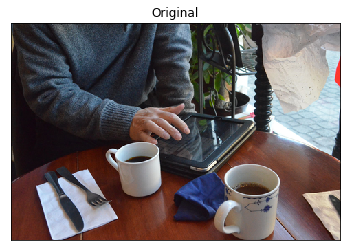

In [13]:
fig = plt.imshow(image)
plt.title('Original')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

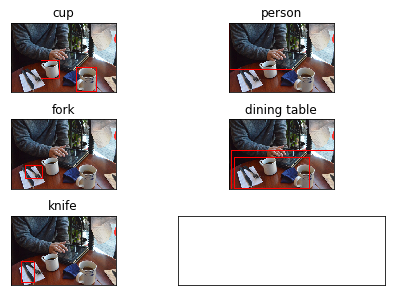

In [14]:
N = len(new_images)
fig, axs = plt.subplots(int(np.ceil(N/2)), 2, constrained_layout=True)

p = 0;
for cls in new_images.keys():
    axs[int(np.floor(p/2)),p%2].imshow(new_images.get(cls))
    axs[int(np.floor(p/2)),p%2].set_title(client.category_index[cls]['name'])
    axs[int(np.floor(p/2)),p%2].get_xaxis().set_visible(False)
    axs[int(np.floor(p/2)),p%2].get_yaxis().set_visible(False)
    p += 1

if p != int(np.ceil(N/2))*2:
    for n in range(p, int(np.ceil(N/2))*2):
        axs[int(np.floor(n/2)),n%2].get_xaxis().set_visible(False)
        axs[int(np.floor(n/2)),n%2].get_yaxis().set_visible(False)

plt.show()